<a href="https://www.kaggle.com/code/sahilr05/tesla-stock-time-series-forecasting?scriptVersionId=106341341" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Flatten
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/tesla-stock-pricing-20172022/TSLA.csv


In [2]:
data = pd.read_csv("/kaggle/input/tesla-stock-pricing-20172022/TSLA.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-18,25.350000,25.974001,25.178667,25.666668,25.666668,107820000
1,2017-09-19,25.333332,25.492666,24.904667,25.006666,25.006666,96778500
2,2017-09-20,24.866667,25.216667,24.738001,24.927334,24.927334,73786500
3,2017-09-21,24.993334,25.122000,24.300667,24.431999,24.431999,69273000
4,2017-09-22,24.432667,24.660000,23.392000,23.406000,23.406000,122391000


In [3]:
data[["Adj Close"]].values

array([[ 25.666668],
       [ 25.006666],
       [ 24.927334],
       ...,
       [302.609985],
       [303.75    ],
       [303.350006]])

In [4]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(data[["Adj Close"]].values)
data["scale_Adj"] = scale.transform(data[["Adj Close"]].values)

In [5]:
data["scale_Adj"]

0      -0.807009
1      -0.812578
2      -0.813247
3      -0.817426
4      -0.826083
          ...   
1254    1.544938
1255    1.441243
1256    1.529666
1257    1.539285
1258    1.535910
Name: scale_Adj, Length: 1259, dtype: float64

In [6]:
# Separate train and test data
train_length = int(len(data["scale_Adj"]) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  1007
Shape of Train and Test data:  1007 252


In [7]:
# train_scale = np.log(train_data["Adj Close"])
# test_scle = np.log(test_data["Adj Close"])

In [8]:
def prepare_data(timeseries_data,n_feature):
    x,y = [] , []
    for i in range(len(timeseries_data)):
        end_ind = i + n_feature
        if end_ind > len(timeseries_data)-1:
            break
        seq_x,seq_y = timeseries_data[i:end_ind], timeseries_data[end_ind]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x),np.array(y)

In [9]:
feature = 3
x_train , y_train = prepare_data(train_data["Adj Close"],feature)
x_test , y_test = prepare_data(test_data["Adj Close"].reset_index(drop=True),feature)

In [10]:
x_train.shape , y_train.shape, x_test.shape , y_test.shape

((1004, 3), (1004,), (249, 3), (249,))

In [11]:
# 2D to 3D
# reshape (1004, 3) to (1004, 3, 1)

x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [12]:
# Build Model 
model = Sequential([
 LSTM(32,activation="relu",return_sequences=False,input_shape=(feature,1)),
 Dense(1),
])
model.compile(optimizer="adam",loss="mse")
history =  model.fit(x_train,y_train,epochs=80,batch_size=32,validation_split=0.1,verbose=0)

2022-09-23 07:18:44.766447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 07:18:44.867212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 07:18:44.867994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 07:18:44.868950: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Text(0.5, 0, 'epoch')

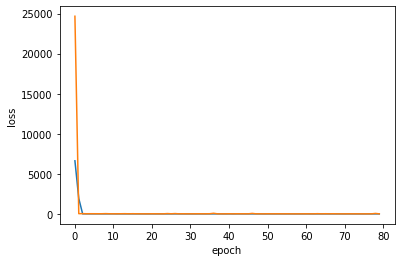

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel('loss')
plt.xlabel('epoch')

In [14]:
import math
from sklearn.metrics import mean_squared_error

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_error = measure_rmse(y_train, train_predict)
test_error = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_error, test_error)

Train and Test RMSE:  4.258445255208953 12.68159398042445


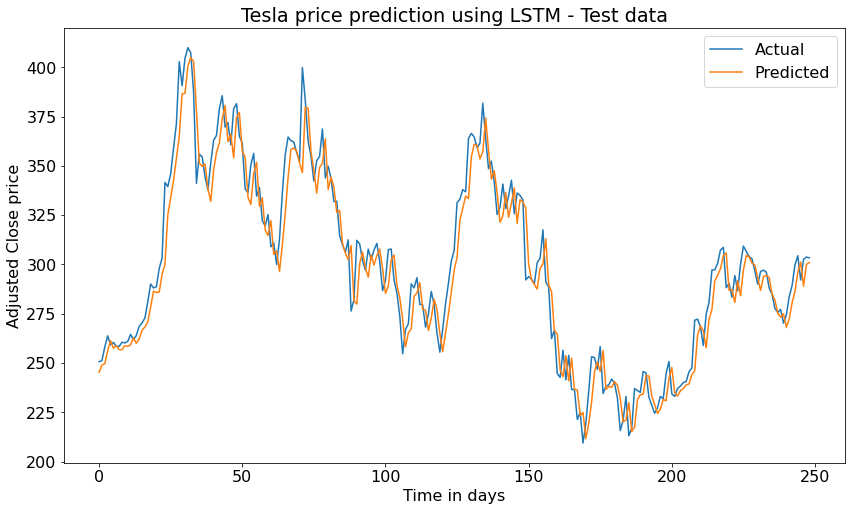

In [15]:
# train_predi = model.predict(x_train)
test_predi = model.predict(x_test)
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label = 'Actual')
plt.plot(test_predi, label = 'Predicted')
plt.xlabel('Time in days')
plt.ylabel('Adjusted Close price')
plt.title('Tesla price prediction using LSTM - Test data')
plt.legend()
plt.show()